Replicating: https://github.com/fastai/fastai/blob/master/courses/dl1/lesson2-image_models.ipynb
        
## Multi-label Classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *

In [4]:
PATH = "data/planet/"

In [6]:
!ls {PATH}

data  fastai_broke  ReadMe.md


## 2 Multi-Label versus Single-Label Classification

In [7]:
from fastai.plots import *

In [8]:
def get_1st(path): return glob(f'{path}/*.*')[0]

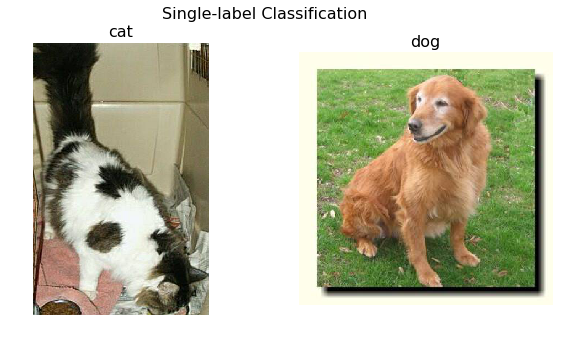

In [10]:
dc_path = "data/dogscats/valid/"
list_paths = [get_1st(f"{dc_path}cats"), get_1st(f"{dc_path}dogs")]
plots_from_files(list_paths, titles=["cat", "dog"], maintitle="Single-label Classification")

In single-label classification each sample belongs to one class. In the previous example, each image is either a dog *or* a cat.

FileNotFoundError: [Errno 2] No such file or directory: 'data/planet/train-jpg/train_0.jpg'

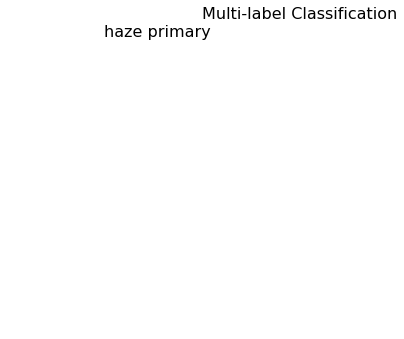

In [11]:
list_paths = [f"{PATH}train-jpg/train_0.jpg", f"{PATH}train-jpg/train_1.jpg"]
titles = ["haze primary", "agriculture clear primary water"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-label Classification")